<a href="https://colab.research.google.com/github/a1869470/Deep_Learning/blob/main/Assessment_2_DL_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fine-tuning and training ResNet...
Epoch 1/10
313/313 [==============================] - 30s 50ms/step - loss: 1.9502 - accuracy: 0.3200 - val_loss: 3.2416 - val_accuracy: 0.1544
Epoch 2/10
313/313 [==============================] - 13s 43ms/step - loss: 1.5929 - accuracy: 0.4355 - val_loss: 1.8233 - val_accuracy: 0.3580
Epoch 3/10
313/313 [==============================] - 14s 44ms/step - loss: 1.4346 - accuracy: 0.4926 - val_loss: 1.9039 - val_accuracy: 0.3330
Epoch 4/10
313/313 [==============================] - 13s 43ms/step - loss: 1.3431 - accuracy: 0.5260 - val_loss: 1.5920 - val_accuracy: 0.4376
Epoch 5/10
313/313 [==============================] - 14s 43ms/step - loss: 1.2659 - accuracy: 0.5526 - val_loss: 2.2395 - val_accuracy: 0.3186
Epoch 6/10
313/313 [==============================] - 14s 43ms/step - loss: 1.1940 - accuracy: 0.5752 - val_loss: 1.6962 - val_accuracy: 0.4032
Epoch 7/10
313/313 [==============================] - 13s 43ms/step - loss: 1.1303 - accuracy: 0.5974

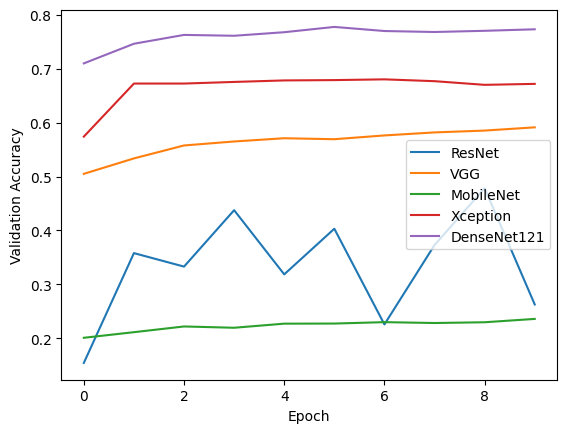

In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50, VGG16, MobileNet, Xception, DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()
num_classes = 10

# Split the full training dataset into training, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Preprocess the data
x_train = x_train.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

# Define function to create a CNN model with fine-tuning
def create_fine_tuned_model(base_model, num_classes, num_frozen_layers=100, learning_rate=0.0001):
    for layer in base_model.layers[:num_frozen_layers]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and compile fine-tuned models
resnet_model = create_fine_tuned_model(ResNet50(weights='imagenet', include_top=False), num_classes)
vgg_model = create_fine_tuned_model(VGG16(weights='imagenet', include_top=False), num_classes)
mobilenet_model = create_fine_tuned_model(MobileNet(weights='imagenet', include_top=False), num_classes)
xception_model = create_fine_tuned_model(Xception(weights='imagenet', include_top=False), num_classes)
densenet_model = create_fine_tuned_model(DenseNet121(weights='imagenet', include_top=False), num_classes)

# Train and evaluate fine-tuned models
models = [resnet_model, vgg_model, mobilenet_model, xception_model, densenet_model]
model_names = ['ResNet', 'VGG', 'MobileNet', 'Xception', 'DenseNet121']
histories = []

for model, model_name in zip(models, model_names):
    print(f"Fine-tuning and training {model_name}...")
    history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))
    histories.append(history)
    score = model.evaluate(x_test, y_test, verbose=0)
    print(f"{model_name} - Test loss: {score[0]}; Test accuracy: {score[1]}")

# Find the two models with the highest test accuracy
top_models = sorted(zip(models, model_names), key=lambda x: x[0].evaluate(x_test, y_test)[1], reverse=True)[:2]

# Evaluate the two best models on the test data
for model, model_name in top_models:
    score = model.evaluate(x_test, y_test, verbose=0)
    print(f"Best Model: {model_name} - Test loss: {score[0]}; Test accuracy: {score[1]}")

# Plot the line graph for validation accuracy
for i, history in enumerate(histories):
    plt.plot(history.history['val_accuracy'], label=f'{model_names[i]}')

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()